**Summary**

In this notebook we explain how to load `passim`'s output into a `pandas`' `DataFrame`, a data structure that comes in very handy when analyzing and/or plotting data.

Please note that if the **size of your data** changes considerably (i.e. the number of detected text reuse clusters shifts from thousands to millions) the use of [`dask` DataFrames](https://docs.dask.org/en/latest/dataframe.html) is recommended, as computation and memory usage can be distributed over a cluster made of several machines. 

## Imports

In [152]:
import os
import pandas as pd

In [154]:
# this prints the current pandas' version
pd.__version__

'1.1.1'

## Configuration

**NB**: In case you speficied a different output folder when running `passim`, you'll need to change the variables here below.

In [4]:
impresso_passim_output_path = os.path.join('.', 'impresso/passim-output/out.json/')

In [151]:
# TODO: add data to GH; for now it will break
eebo_passim_output_path = os.path.join('.', 'eebo/passim-output/out.json/')

## Utility functions

Some very general functions that should be usable with any `passim` JSON output.

In [145]:
def read_passim_json(output_dir: str) -> pd.DataFrame:
    """
    A simple function that reads passim's JSON output
    into a pandas DataFrame.
    """

    # detect all JSON files filtering on file extension
    files = [
        os.path.join(output_dir, f)
        for f in os.listdir(impresso_passim_output_path)
        if f.endswith('.json')
    ]
    
    print(f'{len(files)} files detected in folder {output_dir}')
    
    # read each JSON file into a temporary pandas dataframe
    # thus creating a list of dataframes
    dfs = [
        pd.read_json(file, lines=True)
        for file in files
    ]
    
    # concatenate all temporary dataframes into a single one
    # and set the column `uid` as the dataframe index
    df = pd.concat(dfs).set_index('uid')
    
    n_clusters = df.cluster.nunique()
    n_passages = df.shape[0]
    print(f'Passim data contain {n_passages} text reuse passages, grouped into {n_clusters} clusters')
    return df

def passages2clusters(passages_df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that aggregates passim's output at the cluster-level.
    """
    impresso_tr_clusters = passages_df.groupby('cluster').agg({'size': 'count'})
    impresso_tr_clusters.rename(columns={'size': 'cluster_size'}, inplace=True)
    return impresso_tr_clusters
    

## Read in `passim`'s output for *impresso*

First thing first, we need to read in `passim`'s JSON output; each JSON document represents a *text reuse passage* (not a cluster!) and the data is split over several smallish JSON files contained in `passim`'s output directory.

In [60]:
impresso_tr_passages = read_passim_json(impresso_passim_output_path)

36 files detected in folder ./impresso/passim-output/out.json/
Passim data contain 16101 text reuse passages, grouped into 5458 clusters


In [ ]:
eebo_tr_passages = read_passim_json(eebo_passim_output_path)

## Reshaping data: from passages to clusters

Since `passim`'s JSON represents text reuse passages, in order to do some analysis on text reuse clusters we need to **reshape** our data. This is done by calling the `passages2clusters` function which will transform a DataFrame of passages into a DataFrame of clusters. 

Here, for the sake of semplicity, each cluster has two bits of information (columns): 
1. a cluster ID (the one assigned by `passim`)
2. its size, namely the number of similar/repeated passages that a cluster contains. 

In [125]:
impresso_tr_clusters = passages2clusters(impresso_tr_passages)

In [146]:
impresso_tr_clusters.shape[0]

5458

## Plotting the distribution of cluster sizes

In [150]:
impresso_tr_clusters.cluster_size.value_counts()

2      4545
3       299
4       180
5        84
6        81
7        51
8        49
11       25
10       19
9        14
14       12
12       11
15       10
17        8
13        8
21        7
19        6
16        4
33        4
28        3
24        3
31        3
18        2
50        2
20        2
49        2
35        2
32        2
100       1
120       1
140       1
296       1
59        1
25        1
41        1
45        1
57        1
43        1
22        1
26        1
38        1
42        1
46        1
74        1
23        1
27        1
39        1
81        1
Name: cluster_size, dtype: int64

In [132]:
impresso_tr_clusters.cluster_size.describe()

count    5458.000000
mean        2.949982
std         6.083882
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max       296.000000
Name: cluster_size, dtype: float64

In [149]:
impresso_tr_clusters.quantile(.9)

cluster_size    4.0
Name: 0.9, dtype: float64

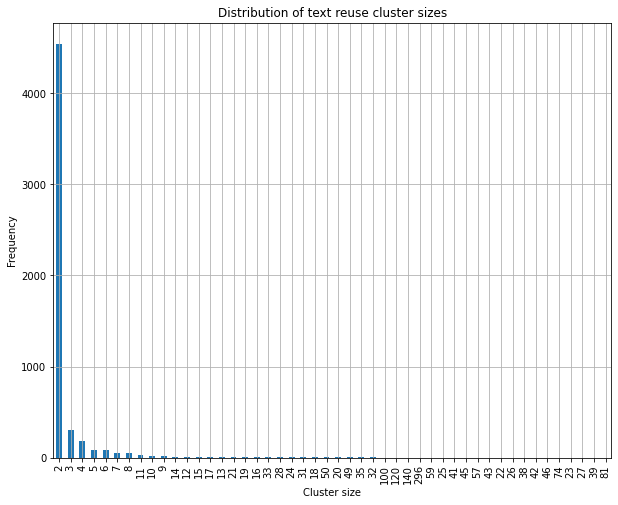

In [129]:
%matplotlib inline
ax = impresso_tr_clusters.cluster_size.value_counts().plot(
    kind='bar',
    log=False,
    grid=True,
    figsize=(10, 8),
    xlabel='Cluster size',
    ylabel='Frequency',
    title='Distribution of text reuse cluster sizes'
)

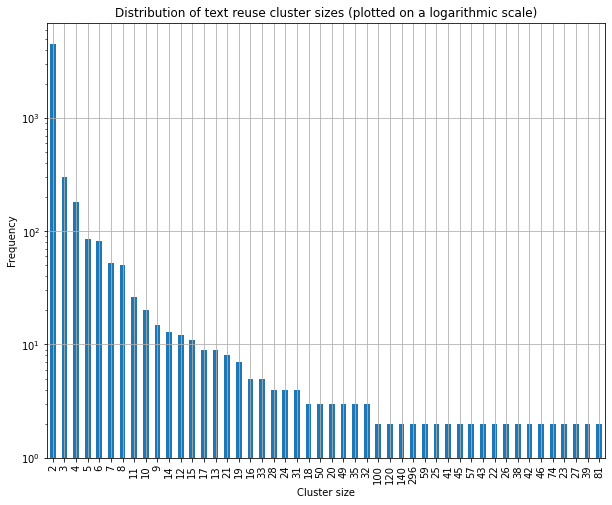

In [131]:
%matplotlib inline
ax = impresso_tr_clusters.cluster_size.value_counts().plot(
    kind='bar',
    log=True,
    grid=True,
    figsize=(10, 8),
    xlabel='Cluster size',
    ylabel='Frequency',
    title='Distribution of text reuse cluster sizes (plotted on a logarithmic scale)'
)